# Flower Recognition

## Importing libraries

In [26]:
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
import pandas as pd

## Paths and variables

In [27]:
TRAIN_PATH = "../dataset/flower_data/train/"
VALID_PATH = "../dataset/flower_data/valid/"
TEST_PATH = "../dataset/test set/"

IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

## Reading flower names from json file

In [28]:
with open("../dataset/cat_to_name.json", "r") as f:
    flower_labels = json.load(f)

print(flower_labels)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [29]:
NUMBER_OF_CLASSES = len(flower_labels)
print("Number of classes:", NUMBER_OF_CLASSES)

Number of classes: 102


## Importing images from training dataset using Image Data Generator

In [30]:
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=mobilenet_v2.preprocess_input
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input
)

In [31]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    seed=1234
)

print(train_gen.class_indices)

Found 6552 images belonging to 102 classes.
{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '

In [32]:
print("Number of batches in training dataset:", len(train_gen))

Number of batches in training dataset: 205


In [33]:
imgs, labels = train_gen.next()
print("Batch shape:", imgs.shape)
print("Min and max pixel values:", imgs[0].min(), imgs[0].max())
print("Labels of images in a sample batch:", labels)

Batch shape: (32, 224, 224, 3)
Min and max pixel values: -1.0 1.0
Labels of images in a sample batch: [ 36.  92.  44.  30.  81.  16.  87.  96.  41.  49.  40.  23.  73.  78.
 100.  49.  62.  82.  86.  56.  72.  49.  82.  41.  93.   1.  63.  76.
  55.  16.  25.  90.]


### Validation dataset

In [34]:
valid_gen = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    seed=1234
)

print(valid_gen.class_indices)

Found 818 images belonging to 102 classes.
{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '9

In [35]:
print("Number of batches in validation dataset:", len(valid_gen))

Number of batches in validation dataset: 26


In [36]:
imgs, labels = valid_gen.next()
print("Batch shape:", imgs.shape)
print("Min and max pixel values:", imgs[0].min(), imgs[0].max())
print("Labels of images in a sample batch:", labels)

Batch shape: (32, 224, 224, 3)
Min and max pixel values: -1.0 1.0
Labels of images in a sample batch: [ 99.  49.  98.  92.  49.  26.  49.  91.  29.  83.  40.  80.  38.  70.
  73.  43.  56.  74.  41. 101.  37.  48.  82.  49.  12.  11.  80.  51.
  85.  86.  54.  90.]


In [37]:
# Checking if train and validation class indices are the same
train_gen.class_indices == valid_gen.class_indices

True

In [38]:
# Saving class names in order like in class_indices dictonary values order as a list
class_names = list(train_gen.class_indices.keys())
print(class_names)

model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
os.makedirs(os.path.dirname(f"../models/{model_version}/"), exist_ok=True)
pickle.dump(class_names, open(f"../models/{model_version}/class_names.p", "wb" ))

['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


## Reading name of files from testing directory

In [39]:
test_set = os.listdir(TEST_PATH)
print(f"There are {len(test_set)} images in test folder without labels.")
print(test_set[:5])

There are 206 images in test folder without labels.
['aa1.jpg', 'aa12.jpg', 'aa11.jpg', 'aa10.jpg', 'aa14.jpg']


In [40]:
# Creating function which returns flower name
def get_flower_name(idx):
    idx = int(idx)
    flower_id = class_names[idx]
    return flower_labels[flower_id]

## Building a classification model

### Loading MobileNetV2 model

In [41]:
mobilenetV2_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    weights="imagenet",  
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    )
mobilenetV2_model.trainable = False

In [42]:
mobilenetV2_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Final model

In [43]:
model = models.Sequential([
    mobilenetV2_model,
    layers.Flatten(), 
    layers.Dense(256, activation='relu'),
    layers.Dense(NUMBER_OF_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               16056576  
                                                                 
 dense_3 (Dense)             (None, 102)               26214     
                                                                 
Total params: 18,340,774
Trainable params: 16,082,790
Non-trainable params: 2,257,984
_________________________________________________________________


In [44]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Training the model

In [45]:
callback = EarlyStopping(monitor='val_loss', 
                         patience=3,
                         verbose=1)

ModelCheck = ModelCheckpoint(filepath=f'../models/{model_version}/model.h5',
                             monitor='val_loss',
                             save_best_only=True)

In [46]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[callback, ModelCheck]
)

Epoch 1/100
205/205 [==============================] - 4518s 22s/step - loss: 4.3486 - accuracy: 0.2732 - val_loss: 2.2886 - val_accuracy: 0.4829
Epoch 2/100
205/205 [==============================] - 110s 538ms/step - loss: 1.6891 - accuracy: 0.5852 - val_loss: 1.6383 - val_accuracy: 0.6125
Epoch 3/100
205/205 [==============================] - 112s 545ms/step - loss: 1.1301 - accuracy: 0.7063 - val_loss: 1.2281 - val_accuracy: 0.7029
Epoch 4/100
205/205 [==============================] - 107s 524ms/step - loss: 0.8826 - accuracy: 0.7654 - val_loss: 1.2503 - val_accuracy: 0.7090
Epoch 5/100
205/205 [==============================] - 110s 539ms/step - loss: 0.7373 - accuracy: 0.8017 - val_loss: 1.1560 - val_accuracy: 0.7286
Epoch 6/100
205/205 [==============================] - 106s 516ms/step - loss: 0.6278 - accuracy: 0.8259 - val_loss: 1.2134 - val_accuracy: 0.7347
Epoch 7/100
205/205 [==============================] - 106s 519ms/step - loss: 0.5925 - accuracy: 0.8391 - val_loss: 1.

Best model after 8 epochs.

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Plotting Loss and Accuracy

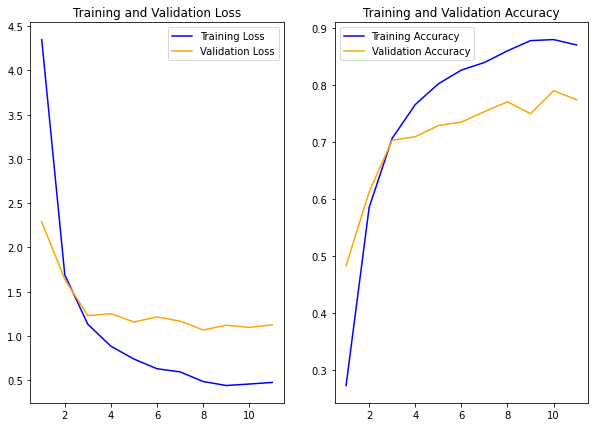

In [48]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss)+1), loss, color='blue', label='Training Loss')
plt.plot(range(1, len(val_loss)+1), val_loss, color='orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy)+1), accuracy, color='blue', label='Training Accuracy')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, color='orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Loading best model

In [49]:
best_model = models.load_model(f'../models/{model_version}/model.h5')
class_names = pickle.load(open(f'../models/{model_version}/class_names.p', 'rb'))

In [50]:
# Loss and Accuracy of validation dataset
best_model.evaluate(valid_gen)

26/26 [==============================] - 6s 215ms/step - loss: 1.0660 - accuracy: 0.7702


[1.0660102367401123, 0.7701711654663086]

## Predicting names of flowers

In [51]:
image_batch, labels_batch = valid_gen.next()
predictions = best_model.predict(image_batch)
print(predictions)

[[7.76051993e-14 1.02742350e-17 2.82429475e-08 ... 1.37442778e-13
  9.70485716e-22 1.57546406e-10]
 [1.83270825e-16 2.37872510e-29 2.60374908e-32 ... 1.33417490e-08
  1.20231010e-22 4.00188042e-20]
 [5.93446314e-01 4.15922045e-07 1.13215179e-07 ... 6.60438847e-04
  2.08468094e-01 3.29544858e-09]
 ...
 [4.07685240e-11 1.37131670e-15 1.26818726e-16 ... 4.46618387e-08
  8.88036844e-09 5.15523700e-11]
 [1.11502877e-05 5.14462215e-07 3.15126722e-12 ... 1.10547504e-07
  8.05132508e-01 6.16170830e-12]
 [3.45564667e-16 7.29698228e-32 1.30278406e-24 ... 8.78139367e-11
  1.83688309e-17 7.80763075e-05]]


In [52]:
for i in range(len(image_batch)):
  print(f"Predicted name: {get_flower_name(np.argmax(predictions[i]))} with {round(max(predictions[i])*100, 2)}% confidence")
  print("True name:", get_flower_name(labels_batch[i]))
  print()

Predicted name: passion flower with 98.55% confidence
True name: passion flower

Predicted name: fritillary with 100.0% confidence
True name: fritillary

Predicted name: pink primrose with 59.34% confidence
True name: pink primrose

Predicted name: pincushion flower with 99.2% confidence
True name: pincushion flower

Predicted name: blanket flower with 99.82% confidence
True name: blanket flower

Predicted name: lotus lotus with 99.67% confidence
True name: lotus lotus

Predicted name: wild pansy with 97.41% confidence
True name: wild pansy

Predicted name: morning glory with 100.0% confidence
True name: morning glory

Predicted name: blanket flower with 98.65% confidence
True name: blanket flower

Predicted name: buttercup with 100.0% confidence
True name: buttercup

Predicted name: poinsettia with 99.95% confidence
True name: poinsettia

Predicted name: oxeye daisy with 99.59% confidence
True name: oxeye daisy

Predicted name: globe thistle with 99.88% confidence
True name: globe thi

## Predicting names of flowers from testing dataset

### Visualization

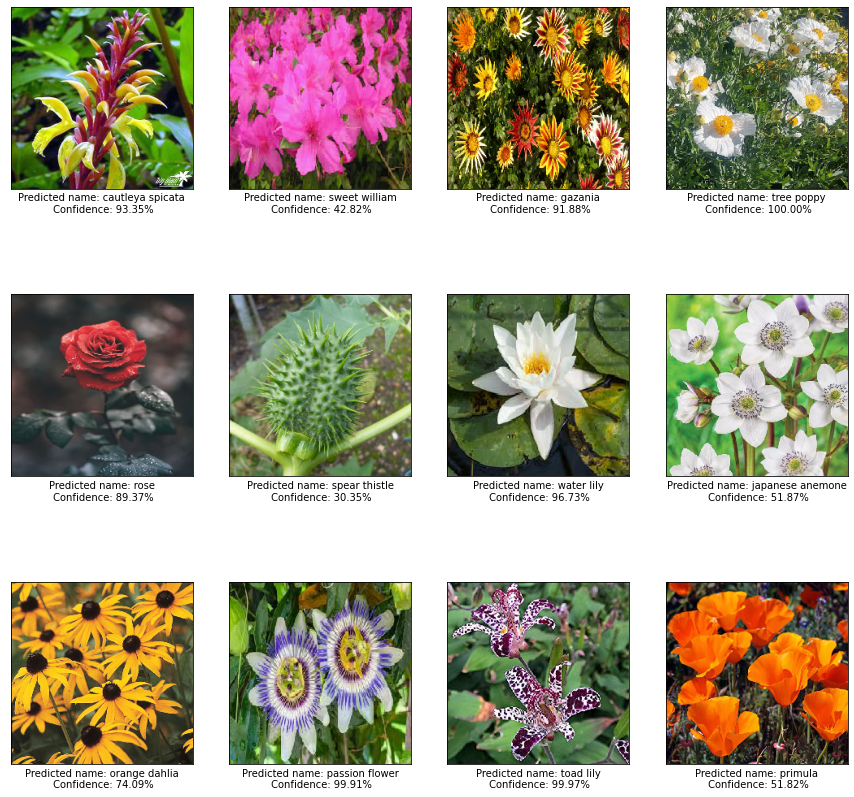

In [53]:
plt.figure(figsize=(15, 15))

for i, file_name in enumerate(os.listdir(TEST_PATH)[:12]):
  img = load_img(TEST_PATH + file_name, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  img = img_to_array(img)

  img_preprocessed = tf.expand_dims(img, axis=0)
  img_preprocessed = mobilenet_v2.preprocess_input(img_preprocessed)
  predictions = best_model.predict(img_preprocessed)[0]
  idx = np.argmax(predictions)
  pred_name = get_flower_name(idx)
  confidence = predictions[idx]

  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(img.astype("uint8"))
  plt.xlabel(f"Predicted name: {pred_name}\n Confidence: {(confidence*100):.2f}%")
  plt.xticks([])
  plt.yticks([])

plt.show()

In [54]:
def preprocess_image(path):
  img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  img = img_to_array(img)
  img = tf.expand_dims(img, axis=0)
  img = mobilenet_v2.preprocess_input(img)
  return img

In [55]:
files = []
predicted_names = []
confidences = []

for file_name in os.listdir(TEST_PATH):
  files.append(file_name)
  file_path = TEST_PATH + file_name
  image = preprocess_image(file_path)

  predictions = best_model.predict(image)[0]
  idx = np.argmax(predictions)
  name = get_flower_name(idx)
  predicted_names.append(name)

  confidence = round(predictions[idx], 2)
  confidences.append(confidence)


In [56]:
count_flowers = Counter(predicted_names)

# sorted dictionary
count_flowers = dict(sorted(count_flowers.items(), key=lambda item: item[1], reverse=True))
count_flowers

{'petunia': 8,
 'cape flower': 6,
 'garden phlox': 6,
 'clematis': 6,
 'tree poppy': 5,
 'japanese anemone': 5,
 'bromelia': 5,
 'cyclamen': 5,
 'sweet william': 4,
 'primula': 4,
 'bee balm': 4,
 'gaura': 4,
 'carnation': 4,
 'ruby-lipped cattleya': 4,
 'grape hyacinth': 4,
 'alpine sea holly': 4,
 'cautleya spicata': 3,
 'rose': 3,
 'spear thistle': 3,
 'water lily': 3,
 'toad lily': 3,
 'lotus lotus': 3,
 'anthurium': 3,
 'lenten rose': 3,
 'bishop of llandaff': 3,
 'monkshood': 3,
 'english marigold': 3,
 'hard-leaved pocket orchid': 3,
 'columbine': 3,
 'wallflower': 3,
 'barbeton daisy': 3,
 'blackberry lily': 3,
 'gazania': 2,
 'orange dahlia': 2,
 'passion flower': 2,
 'morning glory': 2,
 'buttercup': 2,
 'wild pansy': 2,
 'common dandelion': 2,
 'sunflower': 2,
 'poinsettia': 2,
 'king protea': 2,
 'frangipani': 2,
 'fritillary': 2,
 'love in the mist': 2,
 'bird of paradise': 2,
 'pincushion flower': 2,
 'mallow': 2,
 'bolero deep blue': 2,
 'great masterwort': 2,
 'foxglove

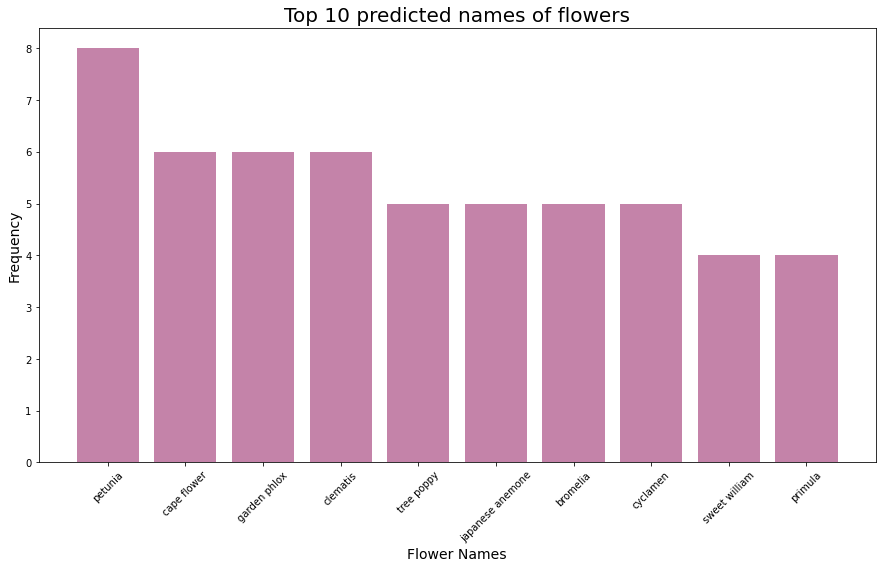

In [57]:
plt.figure(figsize=(15, 8))
plt.bar(range(10), list(count_flowers.values())[:10], color="#c483a9")
plt.xticks(range(10), list(count_flowers.keys())[:10], rotation=45)
plt.title("Top 10 predicted names of flowers", fontsize=20)
plt.xlabel("Flower Names", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

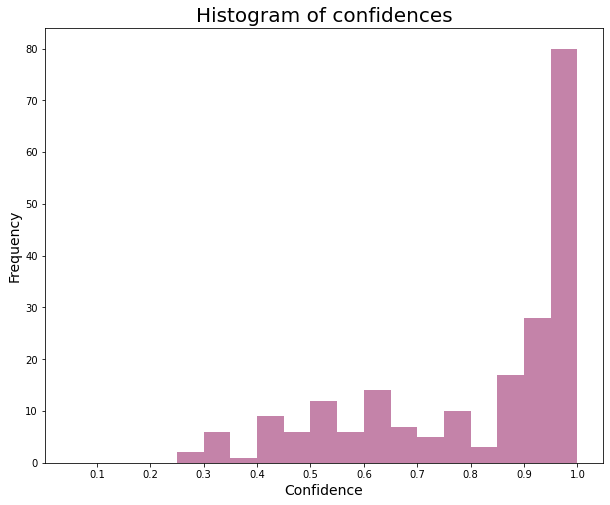

In [75]:
plt.figure(figsize=(10, 8))
plt.hist(confidences, color="#c483a9", bins=[0] + np.linspace(0.05, 1, 20))
plt.title("Histogram of confidences", fontsize=20)
plt.xticks([0] + np.linspace(0.1, 1, 10))
plt.xlabel("Confidence", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

### Writing predictions to csv file

In [76]:
test_predictions = pd.DataFrame({
    'file': files,
    'predicted name': predicted_names,
    'confidence': confidences
})

test_predictions.head(10)

,file,predicted name,confidence
0,aa1.jpg,cautleya spicata,0.93
1,aa12.jpg,sweet william,0.43
2,aa11.jpg,gazania,0.92
3,aa10.jpg,tree poppy,1.00
4,aa14.jpg,rose,0.89
5,aa15.jpg,spear thistle,0.30
6,aa13.jpg,water lily,0.97
7,aa9.jpg,japanese anemone,0.52
8,aa3.jpg,orange dahlia,0.74
9,aa17.jpg,passion flower,1.00


In [78]:
test_predictions.to_csv(f'../models/{model_version}/test_predictions.csv', index=False)